# Person Re-ID on Market-1501 (Ranking)

This is for generating a ranked list of images given a trained model and a query image.

First, import required modules. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../' # Expected to be in rank_scripts/

import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os

In [3]:
#getDiff Implementation
def getDiff( vector1, vector2 ):
    sum=0
    
    for j in range(4096):
        diff= vector1[j]-vector2[j]
        diff=diff*diff
        sum=sum+diff
        
    return math.sqrt(sum)

In [4]:
caffe.set_device(0)
caffe.set_mode_gpu()
net = caffe.Net(caffe_root +  'rank_scripts/rank_alexnet/my_unsup_net_deploy.prototxt',
                caffe_root + 'rank_scripts/models17/_iter_250000.caffemodel',
                caffe.TEST)# input preprocessing: 'data'is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_mean('data', np.load(caffe_root + 'rank_scripts/query_256x128_market.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [5]:
# set net to batch size
net.blobs['data'].reshape(50,3,256,128)

[-1.77515817 -1.8940742  -1.64553189 ..., -1.78660429 -1.46552753
 -0.18331426]


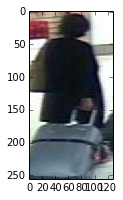

In [9]:
#query_image_path = 'rank_scripts/images_market/0004_c1s6_016996_00.jpg'
query_image_path = '/home/jayant/vision/PETA/i-LID_resize/archive/0001_001.jpg'
query_image = caffe.io.load_image(query_image_path)
#query_image = caffe.io.load_image(caffe_root + query_image_path)
net.blobs['data'].data[...] = transformer.preprocess('data', query_image)
out = net.forward()
vector_query = out['fc7'][0]
plt.figure(figsize=(3,3))
plt.imshow(query_image)
print vector_query

In [1]:
#print net.blobs['conv4'].data[...][0][255]

[-2.07477236 -2.66035008 -2.43379474 ..., -1.2617079  -0.79465359
 -0.1336152 ]


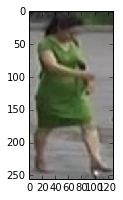

In [39]:
query_image_path = 'rank_scripts/images_market/0049_c2s1_004726_00.jpg'
query_image = caffe.io.load_image(caffe_root + query_image_path)
net.blobs['data'].data[...] = transformer.preprocess('data', query_image)
out = net.forward()
vector_query = out['fc7'][0]
plt.figure(figsize=(3,3))
plt.imshow(query_image)
print vector_query

(batch_size, channel_dim, height, width)

In [8]:
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 256, 128)
conv1	(50, 96, 62, 30)
pool1	(50, 96, 31, 15)
norm1	(50, 96, 31, 15)
conv2	(50, 256, 31, 15)
pool2	(50, 256, 15, 7)
norm2	(50, 256, 15, 7)
conv3	(50, 384, 15, 7)
conv4	(50, 384, 15, 7)
conv5	(50, 256, 15, 7)
pool5	(50, 256, 7, 3)
fc6	(50, 4096)
fc7	(50, 4096)


(output_channels, input_channels, filter_height, filter_width) (for the weights) and the 1-dimensional shape (output_channels,) (for the biases).

In [9]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 5376) (4096,)
fc7	(4096, 4096) (4096,)


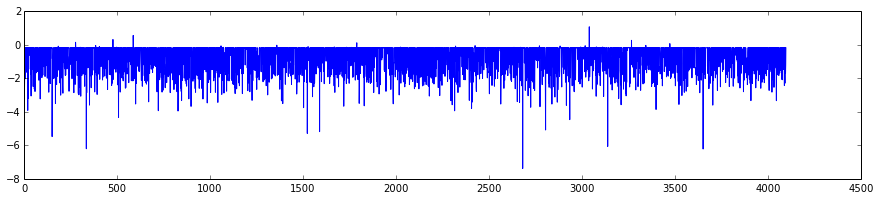

In [10]:
feat = net.blobs['fc7'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

In [11]:
#Rank Vector Setup
num_rank = 6

In [ ]:
#Paired list to hold (diff,imagePath)

Rank_list= []
query_folder = caffe_root + 'rank_scripts/images_market/'
images_list = os.listdir(query_folder)
i=10

#print images_list

for image in images_list:
    new_net = caffe.Net(caffe_root +  'rank_scripts/rank_alexnet/my_unsup_net_deploy.prototxt',
                caffe_root + 'rank_scripts/models17/_iter_250000.caffemodel',
                caffe.TEST)
        
    new_net.blobs['data'].reshape(50,3,256,128)
    new_net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(query_folder + image))
    output=new_net.forward()
    vector_new=output['fc7'][0]
    diff = getDiff(vector_query, vector_new)
    
    #add the pair (diff,image) to the list
    Rank_list.append((diff,image))
    
    #sort the list based on diff
Rank_list.sort()

NewRankList = Rank_list[0:num_rank]

print NewRankList

In [ ]:
fig,axs = plt.subplots (nrows=1,ncols=len(NewRankList))
i=0

for item in NewRankList:
    new_image_name = item[1]
    new_image = caffe.io.load_image(query_folder + new_image_name)
    
    plt.figure(figsize=(3,3))
    axs[i].imshow(new_image)
    i=i+1